In [8]:
import numpy as np
import pandas as pd
from healpy.sphtfunc import smoothing
import smica
import os
import json
import component_separation
from astropy.io import fits
import component_separation.io as io
import healpy as hp
import component_separation.MSC.MSC.pospace as ps
import component_separation.powspec as pw
import component_separation.preprocess as prep
from component_separation.cs_util import Config as csu
from component_separation.cs_util import Constants as const
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Planckf, Planckr, Plancks
import matplotlib.pyplot as plt
with open(os.path.dirname(component_separation.__file__)+'/config.json', "r") as f:
    cf = json.load(f)
    
import platform
uname = platform.uname()
if uname.node == "DESKTOP-KMIGUPV":
    mch = "XPS"
else:
    mch = "NERSC"
signal = pd.read_csv(
        cf[mch]['powspec_truthfile'],
        header=0,
        sep='    ',
        index_col=0)
spectrum_trth = signal["Planck-"+"EE"].to_numpy()

bins = const.SMICA_lowell_bins    #const.linear_equisized_bins_10
def bin_it(data):
    ret = np.ones(len(bins))
    for k in range(bins.shape[0]):
        ret[k] = np.mean(np.nan_to_num(data[int(bins[k][0]):int(bins[k][1])]))
    return np.nan_to_num(ret)

detector = [p.value for p in list(Planckf)]
specfilter = cf['pa']["specfilter"]
freqfilter = cf['pa']["freqfilter"]

<ipython-input-8-63eb2f820e3a>:28: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  signal = pd.read_csv(


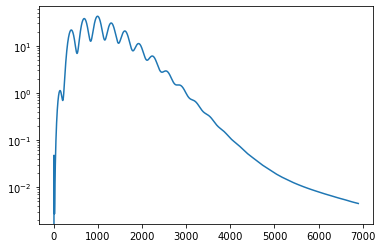

In [3]:
plt.plot(spectrum_trth)
plt.yscale('log')

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/pixelfunc.py:1581: UserWarning: monopole: 1.56359e-14  dipole: lon: 125.572, lat: -89.7208, amp: 2.51984e-14
  warnings.warn(
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to

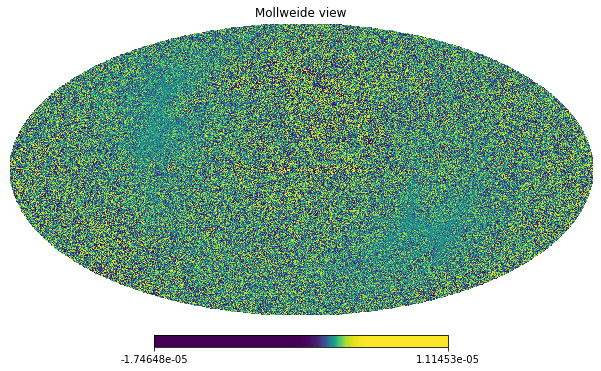

In [2]:
# hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_143_map.fits") <- output?
# hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/input/ffp10_cmb_143_alm_mc_0200.fits") # <- alm
# hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/input/ffp10_cmb_143_alm_mc_0200_nside2048_quickpol.fits") # <- map
# hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/residual/residual_npipe6v20_143_0200.fits") # <- IQU, ring order
hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/noisefix/noisefix_143_0200.fits") # <- IQU, nested order
hdul[1].header
hp.mollview(hdul[1].data.field(0).reshape(-1), nest=True, norm='hist',remove_dip=True)

### npipe6v20_143_map.fits

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                49152 / width of table in bytes                        
NAXIS2  =                12288 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    3 / number of fields in each row                   
TTYPE1  = 'TEMPERATURE'        / label for field   1                            
TFORM1  = '4096E   '           / data format of field: 4-byte REAL              
TUNIT1  = 'K_CMB   '           / physical unit of field                         
TTYPE2  = 'Q-POLARISATION'     / label for field   2                            
TFORM2  = '4096E   '        

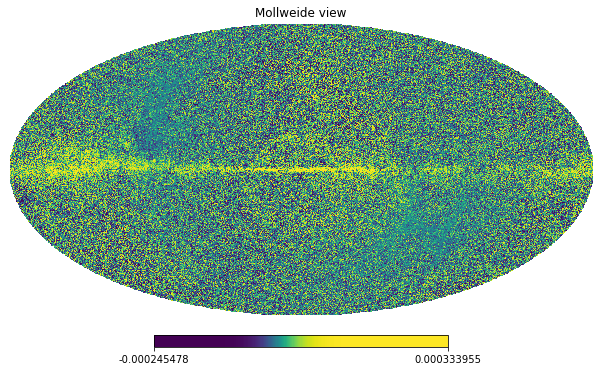

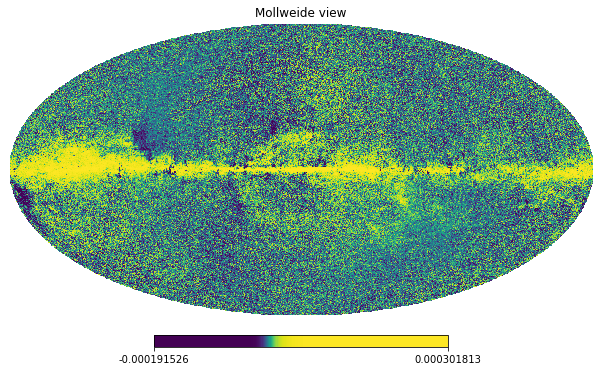

In [148]:
hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_143_map.fits")
hp.mollview(hdul[1].data.field(1).reshape(-1), nest=True, norm='hist')
hdul[1].header
nside_out = 512
hdul0f0dg = hp.ud_grade(hdul[1].data.field(0).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul0f1dg = hp.ud_grade(hdul[1].data.field(1).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul0f2dg = hp.ud_grade(hdul[1].data.field(2).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hp.mollview(hdul0f1dg, nest=False, norm='hist', gal_cut = 15)
hdul[1].header

In [133]:
cl0 = hp.anafast([hdul0f0dg,hdul0f1dg, hdul0f2dg], gal_cut = 5)
print(cl0.shape)

(6, 1536)


/global/common/cori_cle7/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/cori_cle7/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(100.0, 1500.0)

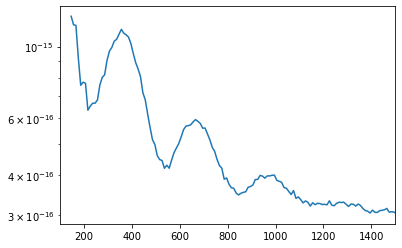

In [131]:
plt.plot(np.mean(bins,axis=1), bin_it(cl0[1]))
plt.yscale('log')
plt.xlim((100,1500))

### input/ffp10_cmb_143_alm_mc_0200.fits
This is what expected cmb looks like

In [3]:
hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/input/ffp10_cmb_143_alm_mc_0200.fits")
# hp.mollview(hdul[1].data.field(1).reshape(-1), nest=True, norm='hist')
real = hdul[1].data.field(1)
imag = hdul[1].data.field(2)
data = real + 1j * imag
# nside_out = 512
# hdul1f0dg = hdul[1].data.field(0).reshape(-1)
# hdul1f1dg = hdul[1].data.field(1).reshape(-1)
# hdul1f2dg = hdul[1].data.field(2).reshape(-1)
# # hp.mollview(hdul1f1dg, nest=True, norm='hist')
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   20 / length of dimension 1                          
NAXIS2  =              8394753 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'index   '                                                            
TFORM1  = 'J       '                                                            
TUNIT1  = 'l*l+l+m+1'                                                           
TTYPE2  = 'real    '                                                            
TFORM2  = 'D       '        

In [7]:
hdul[1].data.field(1)

array([ 0.00000000e+00,  0.00000000e+00,  1.44448504e-05, ...,
       -5.11143445e-10,  1.16268311e-09,  1.35904828e-10])

In [32]:
cl1 = hp.alm2cl(data)
print(cl1.shape)

(4097,)


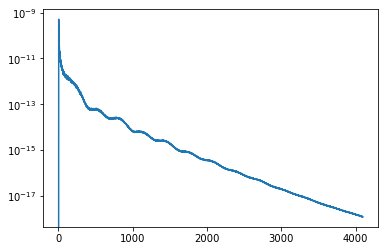

In [36]:
plt.plot(cl1)
# plt.plot(cl1[1])
plt.yscale('log')

### input/ffp10_cmb_143_alm_mc_0200_nside2048_quickpol.fits

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                12288 / length of dimension 1                          
NAXIS2  =                49152 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'TEMPERATURE'                                                         
TFORM1  = '1024E   '                                                            
TTYPE2  = 'Q_POLARISATION'                                                      
TFORM2  = '1024E   '                                                            
TTYPE3  = 'U_POLARISATION'  

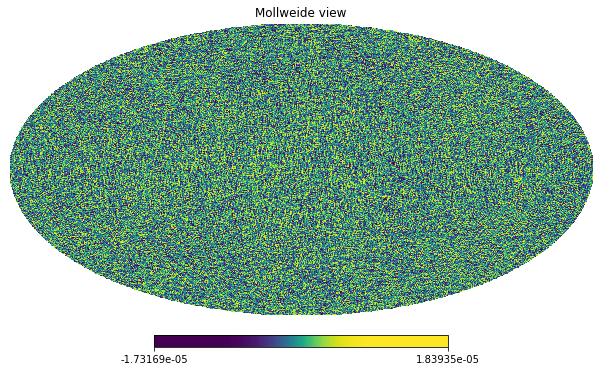

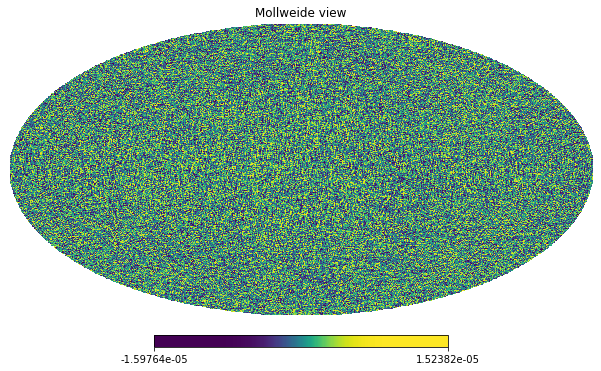

In [136]:
hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/input/ffp10_cmb_143_alm_mc_0200_nside2048_quickpol.fits")
hp.mollview(hdul[1].data.field(1).reshape(-1), nest=True, norm='hist')
hdul[1].header
nside_out = 512
hdul2f0dg = hp.ud_grade(hdul[1].data.field(0).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul2f1dg = hp.ud_grade(hdul[1].data.field(1).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul2f2dg = hp.ud_grade(hdul[1].data.field(2).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hp.mollview(hdul2f1dg, nest=False, norm='hist')
hdul[1].header

In [137]:
cl2 = hp.anafast([hdul2f0dg,hdul2f1dg, hdul2f2dg])
print(cl2.shape)

(6, 1536)


/global/common/cori_cle7/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/cori_cle7/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


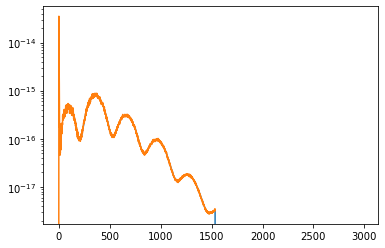

In [140]:
plt.plot(np.mean(bins,axis=1), bin_it(cl2[1]))
plt.plot(cl2[1])
plt.yscale('log')

### residual/residual_npipe6v20_143_0200.fits

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                12288 / length of dimension 1                          
NAXIS2  =                49152 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'TEMPERATURE'                                                         
TFORM1  = '1024E   '                                                            
TTYPE2  = 'Q_POLARISATION'                                                      
TFORM2  = '1024E   '                                                            
TTYPE3  = 'U_POLARISATION'  

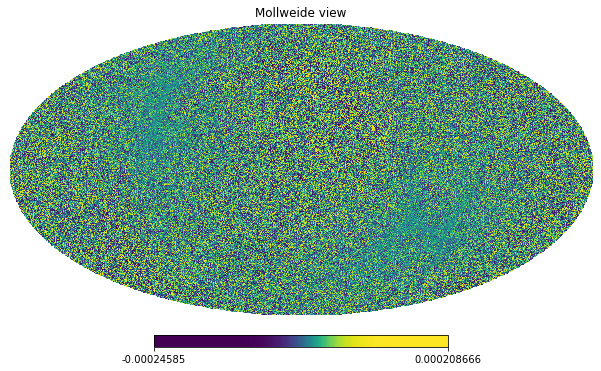

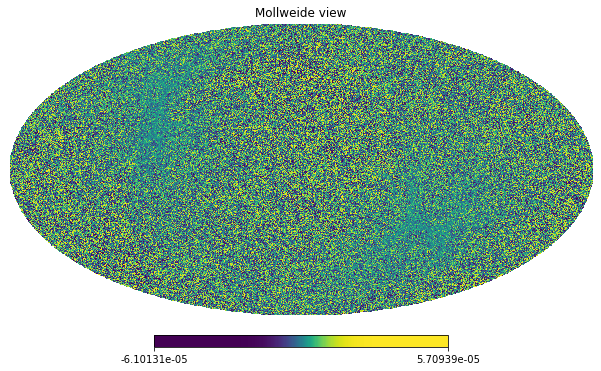

In [43]:
hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/residual/residual_npipe6v20_143_0200.fits")
hp.mollview(hdul[1].data.field(1).reshape(-1), norm='hist')
hdul[1].header
nside_out = 512
hdul3f0dg = hp.ud_grade(hdul[1].data.field(0).reshape(-1), nside_out = nside_out)
hdul3f1dg = hp.ud_grade(hdul[1].data.field(1).reshape(-1), nside_out = nside_out)
hdul3f2dg = hp.ud_grade(hdul[1].data.field(2).reshape(-1), nside_out = nside_out)
hp.mollview(hdul3f1dg, norm='hist')
hdul[1].header

In [41]:
cl3 = hp.anafast([hdul3f0dg,hdul3f1dg, hdul3f2dg])
print(cl3.shape)

(6, 1536)


(2e-16, 1e-15)

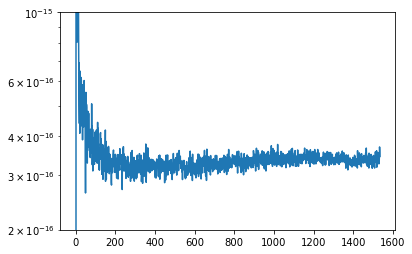

In [45]:
plt.plot(cl3[1])
plt.yscale('log')
plt.ylim((2e-16,1e-15))

### noisefix/noisefix_100_0200.fits

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                12288 / length of dimension 1                          
NAXIS2  =                49152 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'TEMPERATURE'                                                         
TFORM1  = '1024E   '                                                            
TTYPE2  = 'Q_POLARISATION'                                                      
TFORM2  = '1024E   '                                                            
TTYPE3  = 'U_POLARISATION'  

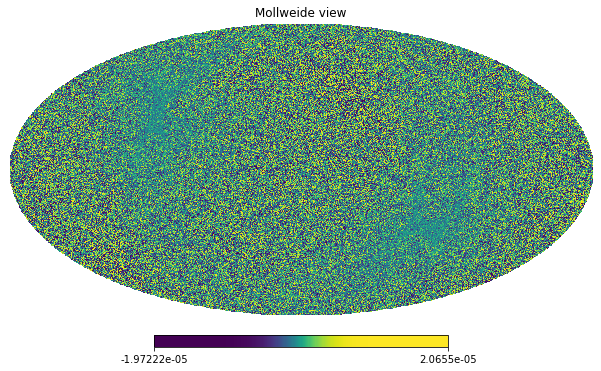

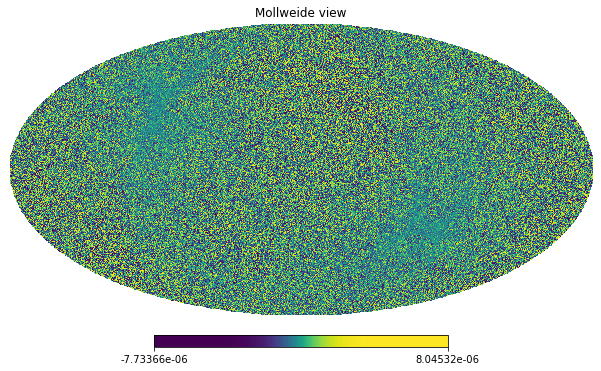

In [144]:
hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/noisefix/noisefix_100_0200.fits")
hp.mollview(hdul[1].data.field(1).reshape(-1), norm='hist', nest=True)
hdul[1].header
nside_out = 512
hdul4f0dg = hp.ud_grade(hdul[1].data.field(0).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul4f1dg = hp.ud_grade(hdul[1].data.field(1).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul4f2dg = hp.ud_grade(hdul[1].data.field(2).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hp.mollview(hdul4f1dg, norm='hist', nest=False)
hdul[1].header

In [142]:
cl4 = hp.anafast([hdul4f0dg,hdul4f1dg, hdul4f2dg])
print(cl4.shape)

(6, 1536)


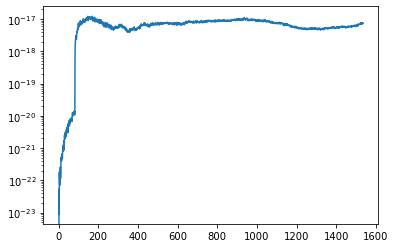

In [143]:
plt.plot(cl4[1])
plt.yscale('log')
# plt.ylim((2e-16,1e-15))

### half_ring

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                49152 / width of table in bytes                        
NAXIS2  =                12288 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    3 / number of fields in each row                   
TTYPE1  = 'TEMPERATURE'        / label for field   1                            
TFORM1  = '4096E   '           / data format of field: 4-byte REAL              
TUNIT1  = 'K_CMB   '           / physical unit of field                         
TTYPE2  = 'Q-POLARISATION'     / label for field   2                            
TFORM2  = '4096E   '        

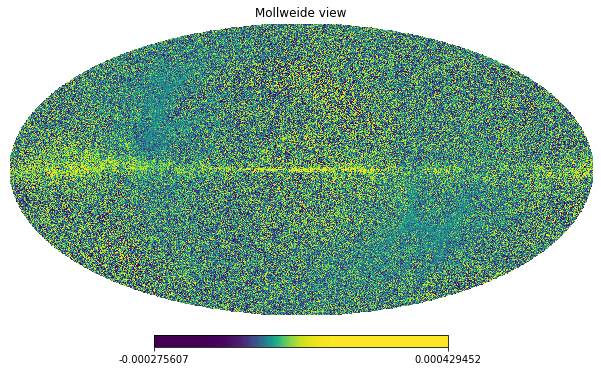

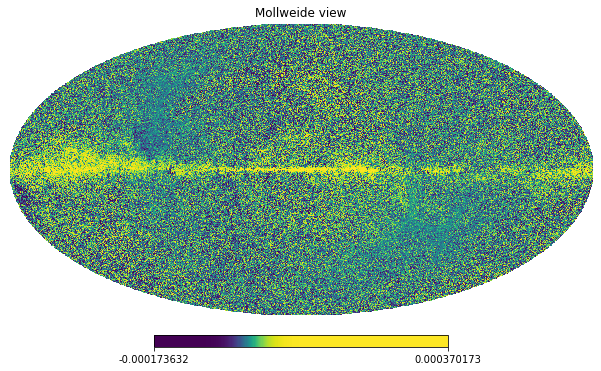

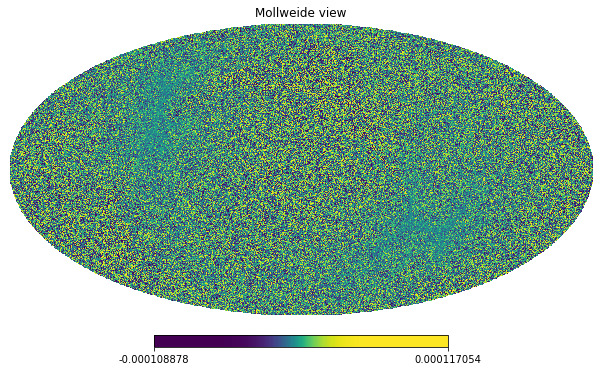

In [145]:
hdul1 = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/half_ring/npipe6v20_143_map_sub1of2.fits")
hdul2 = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/half_ring/npipe6v20_143_map_sub2of2.fits")
hp.mollview(hdul1[1].data.field(1).reshape(-1), norm='hist', nest=True)
hdul1[1].header
nside_out = 512
hdul14f0dg = hp.ud_grade(hdul1[1].data.field(0).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul14f1dg = hp.ud_grade(hdul1[1].data.field(1).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul14f2dg = hp.ud_grade(hdul1[1].data.field(2).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')

hdul24f0dg = hp.ud_grade(hdul2[1].data.field(0).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul24f1dg = hp.ud_grade(hdul2[1].data.field(1).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul24f2dg = hp.ud_grade(hdul2[1].data.field(2).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')

hp.mollview(hdul14f1dg, norm='hist', nest=False)


d1_hdulf0dg = (hdul14f0dg - hdul24f0dg)/2.
d1_hdulf1dg = (hdul14f1dg - hdul24f1dg)/2.
d1_hdulf2dg = (hdul14f2dg - hdul24f2dg)/2.
hp.mollview(d1_hdulf1dg, norm='hist', nest=False)

hdul1[1].header

In [146]:
dcl5 = hp.anafast([d1_hdulf0dg,d1_hdulf1dg, d1_hdulf2dg])
print(dcl5.shape)

(6, 3072)


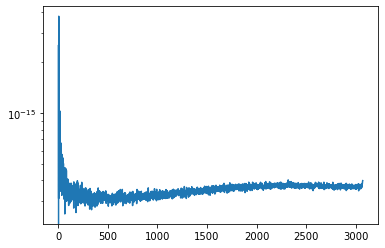

In [147]:
plt.plot(dcl5[1])
plt.yscale('log')
# plt.ylim((2e-16,1e-15))

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/he

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4096 / length of dimension 1                          
NAXIS2  =                49152 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'I       '                                                            
TFORM1  = '1024E   '                                                            
PIXTYPE = 'HEALPIX '           / HEALPIX pixelisation                           
ORDERING= 'RING    '           / Pixel ordering scheme, either RING or NESTED   
EXTNAME = 'xtension'        

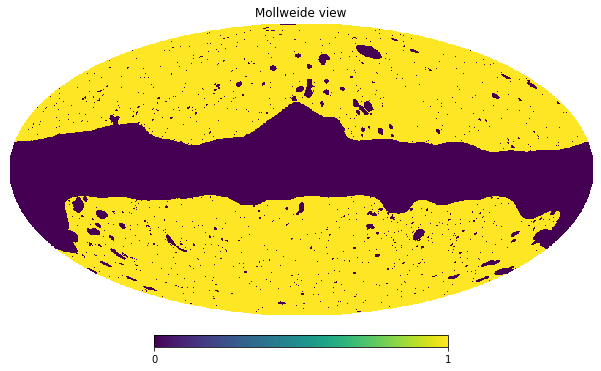

In [2]:
import healpy as hp
from astropy.io import fits
pmask = hp.read_map("/global/homes/s/sebibel/data/mask/PR3vJan18_temp_lensingmask_gPR2_70_psPR2_143_COT2_smicadx12_smicapoldx12_psPR2_217_sz.fits.gz")
hdul = fits.open("/global/homes/s/sebibel/data/mask/PR3vJan18_temp_lensingmask_gPR2_70_psPR2_143_COT2_smicadx12_smicapoldx12_psPR2_217_sz.fits.gz")
hp.mollview(pmask)
hdul[1].header

# Look into Smica output

In [2]:
theta = io.load_data("/global/cscratch1/sd/sebibel/smica/theta.npy")
cov4D = io.load_data("/global/cscratch1/sd/sebibel/smica/cov4D.npy")
cov = io.load_data("/global/cscratch1/sd/sebibel/smica/cov.npy")


C_ltot = io.load_data(path_name=io.spec_sc_path_name)
cov_ltot = pw.build_covmatrices(C_ltot, lmax=lmax, freqfilter=freqfilter, specfilter=specfilter)

loaded /global/cscratch1/sd/sebibel/smica/theta.npy
loaded /global/cscratch1/sd/sebibel/smica/cov4D.npy
loaded /global/cscratch1/sd/sebibel/smica/cov.npy
loaded /global/cscratch1/sd/sebibel/spectrum/NPIPE_sim/SPEC0200_C_l_NPIPE_sim_lens_3000_6000_0_0_Full.npy


NameError: name 'lmax' is not defined

In [3]:
print(theta.shape)
print(cov.shape)
print(cov4D.shape)

(98, 1)
(7, 7, 10)
(7, 7, 10, 3)


ValueError: x and y must have same first dimension, but have shapes (10,) and (98, 1)

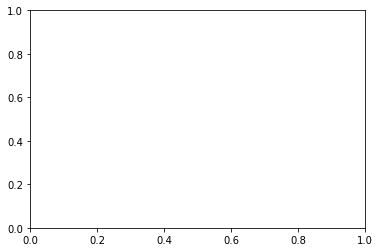

In [7]:
plt.plot(np.mean(bins, axis=1), theta)

In [15]:
from astropy.io import fits
freq1 = '030'
freq2 = '143'
split = ''
splitvariation = 'GHz'
hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20{split}/quickpol/Bl_TEB_npipe6v20_{freq1}{splitvariation}x{freq2}{splitvariation}.fits".replace('{freq1}', freq1).replace('{freq2}', freq2).replace('{splitvariation}', splitvariation).replace('{split}', split))


In [19]:
hdul[1].data

FITS_rec([(1.0, 1.0, 1.0), (0.99999136, 0.99999136, 0.99999136),
          (0.99997365, 0.99997371, 0.99997371), ...,
          (-7.2745422e-07, -2.6275416e-07, 1.2180692e-06),
          (-1.1681708e-06, -4.0091669e-07, 1.2275497e-06),
          (-1.4973309e-06, -4.9824149e-07, 1.2475145e-06)],
         dtype=(numpy.record, [('T', 'S15'), ('E', 'S15'), ('B', 'S15')]))

In [20]:
cf['pa']['freqdset'].startswith('NPIPE')

True